In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [2]:
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(395, 488, 3)
)

In [3]:
# Extracting the VGG19 features and corresponding labels
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg19.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

In [4]:
# Path to the images
path_to_images = "training-data/dataset1/known_images"

In [5]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    path_to_images,
    class_names=["normal", "sick"],
    batch_size = 32,
    image_size=(395, 488),
    validation_split=0.2,
    subset="both",
    seed=200
)

Found 715 files belonging to 2 classes.
Using 572 files for training.
Using 143 files for validation.


In [6]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(val_dataset)
# test_featues, test_labels = get_features_and_labels(test_dataset)

2023-05-18 07:47:15.137791: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 5s 5s/step


In [7]:
train_features.shape

(572, 12, 15, 512)

In [8]:
inputs = keras.Input(shape=(12, 15, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [9]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        keras.metrics.Accuracy(),
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.AUC(),
        keras.metrics.Recall(),
        keras.metrics.TruePositives(),
        keras.metrics.FalsePositives(),
        keras.metrics.TrueNegatives(),
        keras.metrics.FalseNegatives()
    ]
)

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/chest-opacities-detection-with-VGG19-pretrained-model.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [11]:
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/30
18/18 [==============================] - 1s 56ms/step - loss: 50.3729 - accuracy: 0.7815 - binary_accuracy: 0.8217 - precision: 0.8235 - auc: 0.8297 - recall: 0.8235 - true_positives: 238.0000 - false_positives: 51.0000 - true_negatives: 232.0000 - false_negatives: 51.0000 - val_loss: 4.9754 - val_accuracy: 0.9510 - val_binary_accuracy: 0.9650 - val_precision: 1.0000 - val_auc: 0.9597 - val_recall: 0.9194 - val_true_positives: 57.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 81.0000 - val_false_negatives: 5.0000
Epoch 2/30
18/18 [==============================] - 1s 43ms/step - loss: 0.9433 - accuracy: 0.9755 - binary_accuracy: 0.9878 - precision: 0.9896 - auc: 0.9895 - recall: 0.9862 - true_positives: 285.0000 - false_positives: 3.0000 - true_negatives: 280.0000 - false_negatives: 4.0000 - val_loss: 1.1365 - val_accuracy: 0.9580 - val_binary_accuracy: 0.9720 - val_precision: 0.9833 - val_auc: 0.9776 - val_recall: 0.9516 - val_true_positives: 59.0000 - val_fal

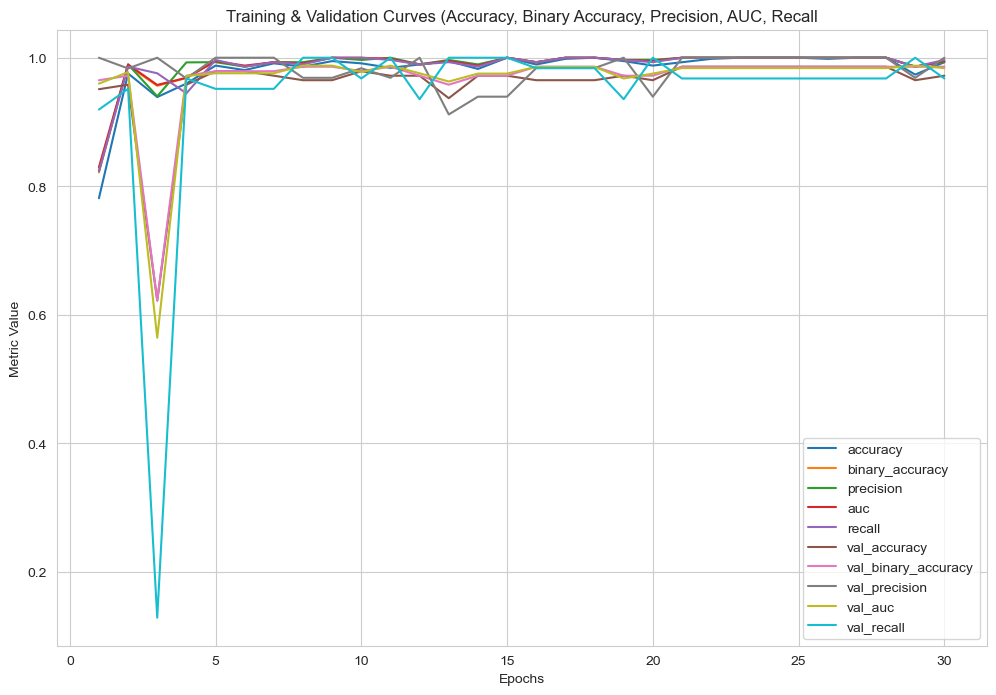

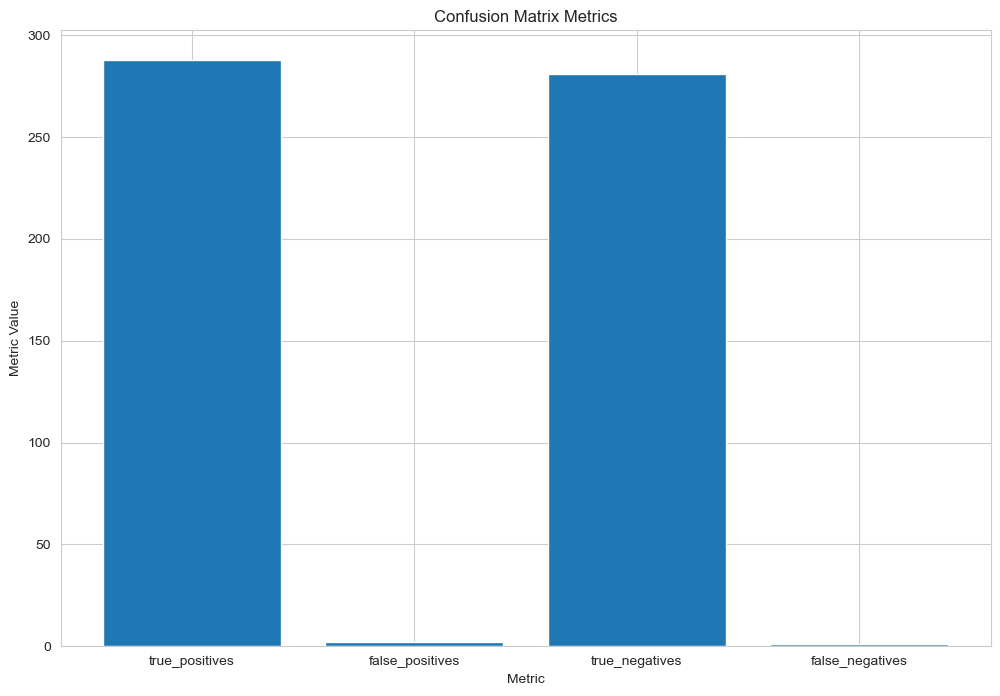

In [13]:
# Define the training metrics for line curves
training_line_metrics = [
    'accuracy',
    'binary_accuracy',
    'precision',
    'auc',
    'recall',
    'val_accuracy',
    'val_binary_accuracy',
    'val_precision',
    'val_auc',
    'val_recall'
]

# Define the validation metrics for the line curves
validation_line_metrics = [
    'val_accuracy',
    'val_binary_accuracy',
    'val_precision',
    'val_auc',
    'val_recall'
]

# Define the metrics for the confusion matrix
confusion_matrix_metrics = [
    'true_positives',
    'false_positives',
    'true_negatives',
    'false_negatives'
]

# Create separate figures for line curves and confusion matrix
line_fig, line_ax = plt.subplots(figsize=(12, 8))
confusion_matrix_fig, confusion_matrix_ax = plt.subplots(figsize=(12, 8))

# Plot line curves for line metrics
for metric in training_line_metrics:
    values = history.history[metric]
    epochs = range(1, len(values) + 1)
    line_ax.plot(epochs, values, label=metric)

line_ax.set_xlabel('Epochs')
line_ax.set_ylabel('Metric Value')
line_ax.set_title('Training & Validation Curves (Accuracy, Binary Accuracy, Precision, AUC, Recall')
line_ax.legend()

# Plot bar graphs for confusion matrix metrics
confusion_matrix_values = [
    history.history[metric][-1] for metric in confusion_matrix_metrics
]

confusion_matrix_ax.bar(confusion_matrix_metrics, confusion_matrix_values)
confusion_matrix_ax.set_xlabel('Metric')
confusion_matrix_ax.set_ylabel('Metric Value')
confusion_matrix_ax.set_title('Confusion Matrix Metrics')

# Show the plots
plt.show()

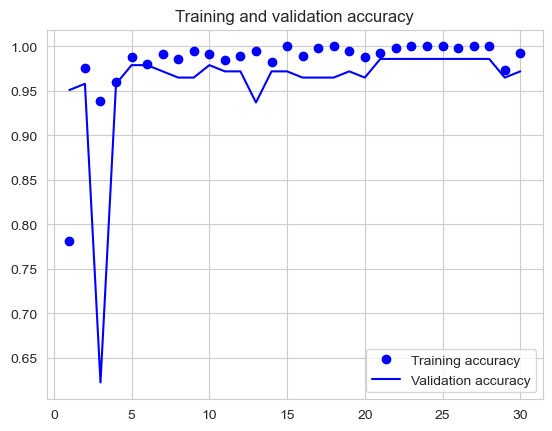

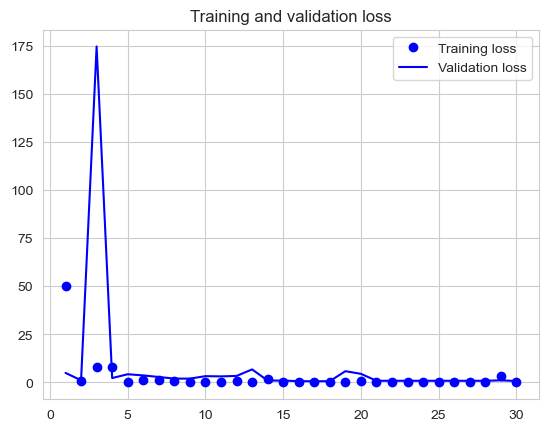

In [44]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Accuracy plots
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

# Loss plots
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [15]:
model = keras.models.load_model("models/chest-opacities-detection-with-VGG19-pretrained-model.keras")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 15, 512)]     0         
                                                                 
 flatten (Flatten)           (None, 92160)             0         
                                                                 
 dense (Dense)               (None, 256)               23593216  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23,593,473
Trainable params: 23,593,473
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Define the directory containing the test images
test_dir = "training-data/dataset1/unknown_images"

# Get the list of test image file paths
test_image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

In [40]:
# Create an empty array to store predictions and file names
predictions_with_filenames = []

# Loop through each test image, make predictions and store the predicted label
for image_path in test_image_paths:
    # Load the image and resize it to the target size
    img = keras.preprocessing.image.load_img(image_path, target_size=(395, 488))

    # Convert the image to a numpy array
    img_array = keras.preprocessing.image.img_to_array(img)

    # Expand the dimensions of the array to create a batch axis
    img_array = np.expand_dims(img_array, axis=0)

    # preprocessing the images
    img_array = keras.applications.vgg19.preprocess_input(img_array)

    # Make predictions on the image
    predictions = model.predict(img_array)

    # Convert the predictions to a binary label (0 for Normal, 1 for Sick)
    predicted_label = int(predictions[0] > 0.5)

    # Extract the file name from the image path
    file_name = os.path.basename(image_path)

    # Add the predicted label and file name to the list
    predictions_with_filenames.append((file_name, predicted_label))

ValueError: cannot reshape array of size 578280 into shape (12,15,512)

In [ ]:
# Save the predictions with file names as a CSV file
with open('chest_opacities_model_predictions_Matovu_Ronald_2022_HD05_22303U.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Add name and registration number to file
    writer.writerow(['Name:', 'Matovu Ronald'])
    writer.writerow(['Registration Number:', '2022/HD05/22303U'])
    writer.writerow(['File Name', 'Predicted Label'])
    for prediction in predictions_with_filenames:
        writer.writerow(prediction)

In [19]:
path_to_dataset_2 = "training-data/dataset2/images"

In [20]:
test_dataset = keras.utils.image_dataset_from_directory(
    path_to_dataset_2,
    class_names=["normal", "sick"],
    batch_size = 32,
    image_size=(395, 488),
)

Found 224 files belonging to 2 classes.


In [21]:
test_model = keras.models.load_model("models/chest-opacities-detection-with-VGG19-pretrained-model.keras")

In [22]:
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 11s 11s/step


In [25]:
test_results = test_model.evaluate(test_features, test_labels)

7/7 [==============================] - 0s 8ms/step - loss: 556.0605 - accuracy: 0.4464 - binary_accuracy: 0.4509 - precision: 0.4739 - auc: 0.4509 - recall: 0.8929 - true_positives: 100.0000 - false_positives: 111.0000 - true_negatives: 1.0000 - false_negatives: 12.0000


In [43]:
print(test_results)

[556.060546875, 0.4464285671710968, 0.4508928656578064, 0.4739336371421814, 0.4508928656578064, 0.8928571343421936, 100.0, 111.0, 1.0, 12.0]


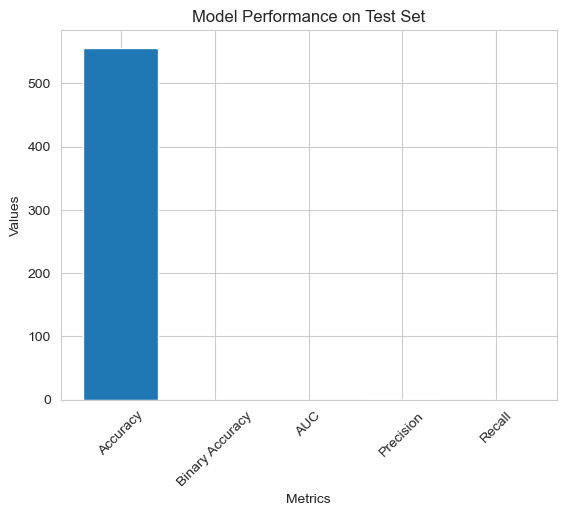

In [42]:
# Define the metrics and their corresponding values
metrics = ['Accuracy', 'Binary Accuracy', 'AUC', 'Precision', 'Recall']
values = test_results[:5]  # Assuming the test_results contain the metrics in the same order

# Plot the bar graph
plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance on Test Set')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()